Scikit-Learn The Random Team Lab 2

In [27]:
#import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import random
import os

#processing imports
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


#model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [28]:
#Display as much columns as possible
pd.set_option('display.max_columns', None)
# get current directory
current_dir = os.getcwd()

Extracting Data from NSL-KDD Dataset

In [29]:
#fetch file
file_path_20_percent = os.path.join(current_dir, 'dataset','KDDTrain+_20Percent.txt')
file_path_full_training_set = os.path.join(current_dir, 'dataset','KDDTrain+.txt')
file_path_test = os.path.join(current_dir, 'dataset','KDDTest+.txt' )

#create dataframe
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [30]:
display(df.describe(include = [object]))

,tcp,ftp_data,SF,normal
count,125972,125972,125972,125972
unique,3,70,11,23
top,tcp,http,SF,normal
freq,102688,40338,74944,67342


Formatting with Columns

In [31]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# test dataframe's format and drop training and testing ratios to where 25% is 
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


Creating Classifiers :column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack.

In [32]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


Transforming our Data for Classification

Classify each of the attacks according to attack type for a prediction model.

Denial of Service attacks:
apache2
back
land
neptune
mailbomb
pod
processtable
smurf
teardrop
udpstorm
worm

Probe attacks:
ipsweep
mscan
nmap
portsweep
saint
satan

Privilege escalation attacks:
buffer_overflow
loadmdoule
perl
ps
rootkit
sqlattack
xterm

Remote access attacks:
ftp_write
guess_passwd
http_tunnel
imap
multihop
named
phf
sendmail
snmpgetattack
snmpguess
spy
warezclient
warezmaster
xclock
xsnoop

In [33]:
#Place attack classifications into lists
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

#Create attack labels
attack_labels = ['Normal', 'DOS', 'Probe', 'Privilege', 'Access']


#Function for mapping our class labels to attack types
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks map to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
train_attack_map = df.attack.apply(map_attack)
df['attack_map'] = train_attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head(100)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.00,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.00,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20,0.20,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00,0.00,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.00,0.00,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,udp,other,SF,102,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.0,0.0,1.00,0.00,0.00,7,1,0.14,0.29,0.14,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
96,0,tcp,http,SF,259,750,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.00,0.00,0.40,4,255,1.00,0.00,0.25,0.03,0.00,0.00,0.0,0.00,normal,21,0,0
97,1082,udp,other,SF,147,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.00,0.00,0.00,255,2,0.01,0.42,0.86,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
98,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,16,1.00,1.00,0.0,0.0,0.12,0.05,0.00,255,12,0.05,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,21,1,1


Data Distribution

In [34]:

#Count the frequency of different types of attack (class labels)
train_attack_counts = df['attack_map'].value_counts()
test_attack_counts = test_df['attack_map'].value_counts()


#Calculate training percentages with overall count of the dataframe
train_attack_percentages = 100 * train_attack_counts / len(df)

train_attack_percentages = round(train_attack_percentages, 2)

train_attack_percentages = train_attack_percentages.round(2).astype(str) + "%"

#Calculate testing percentages with overall count of the dataframe
test_attack_percentages = 100 * test_attack_counts / len(test_df)

test_attack_percentages = round(test_attack_percentages, 2)

test_attack_percentages = test_attack_percentages.round(2).astype(str) + "%"

distribution_columns = {"Class": attack_labels, "Training Set": train_attack_counts, "Train-SET Percentage": train_attack_percentages, "Testing Set": test_attack_counts, "Test-SET Percentage": test_attack_percentages} 

distribution_df = pd.DataFrame(distribution_columns)

distribution_df.head()


,Class,Training Set,Train-SET Percentage,Testing Set,Test-SET Percentage
0,Normal,67351,53.47%,9855,43.72%
1,DOS,45927,36.46%,7459,33.09%
2,Probe,11656,9.25%,2421,10.74%
3,Privilege,43,0.03%,65,0.29%
4,Access,995,0.79%,2743,12.17%


Classification Process

In [35]:
def compute_metrics(predictions, true_labels):
    labels = true_labels
    preds = predictions
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,
                                                               average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Feature Engineering

Discrete Features: **protocol_type** (tcp, udp, etc mapped to numbers: 0,1,2) 

**service** (service running on the destination (telnet, http, etc mapped to numbers: 0,1, 2)

**flag** (normal or error status of the connection, 0 or 1)
                  

Continious features 

**Duration** (length (number of seconds) of the connection)

**srv_diff_host_rate** (% of connections to different hosts)

**dst_bytes** (number of data bytes flowing from destination to source) 	






In [36]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'srv_diff_host_rate', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [37]:
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

Decision Tree Model

In [38]:
binary_model = DecisionTreeClassifier()
binary_model.fit(binary_train_X, binary_train_y)
y_pred = binary_model.predict(binary_val_X)

metrics_list = compute_metrics(y_pred, binary_val_y)
    #---------------------------------------------------------------#
results = pd.DataFrame(metrics_list, columns = ['accuracy', 'precision', 'recall', 'f1'], index=[0])
results['Type'] = 'Classical Machine Learning'
results['Model'] = 'Decision Tree C4.5'
results = results[['Type', 'Model', 'accuracy', 'precision', 'recall', 'f1']]
display(results)

,Type,Model,accuracy,precision,recall,f1
0,Classical Machine Learning,Decision Tree C4.5,0.981292,0.981133,0.981269,0.9812


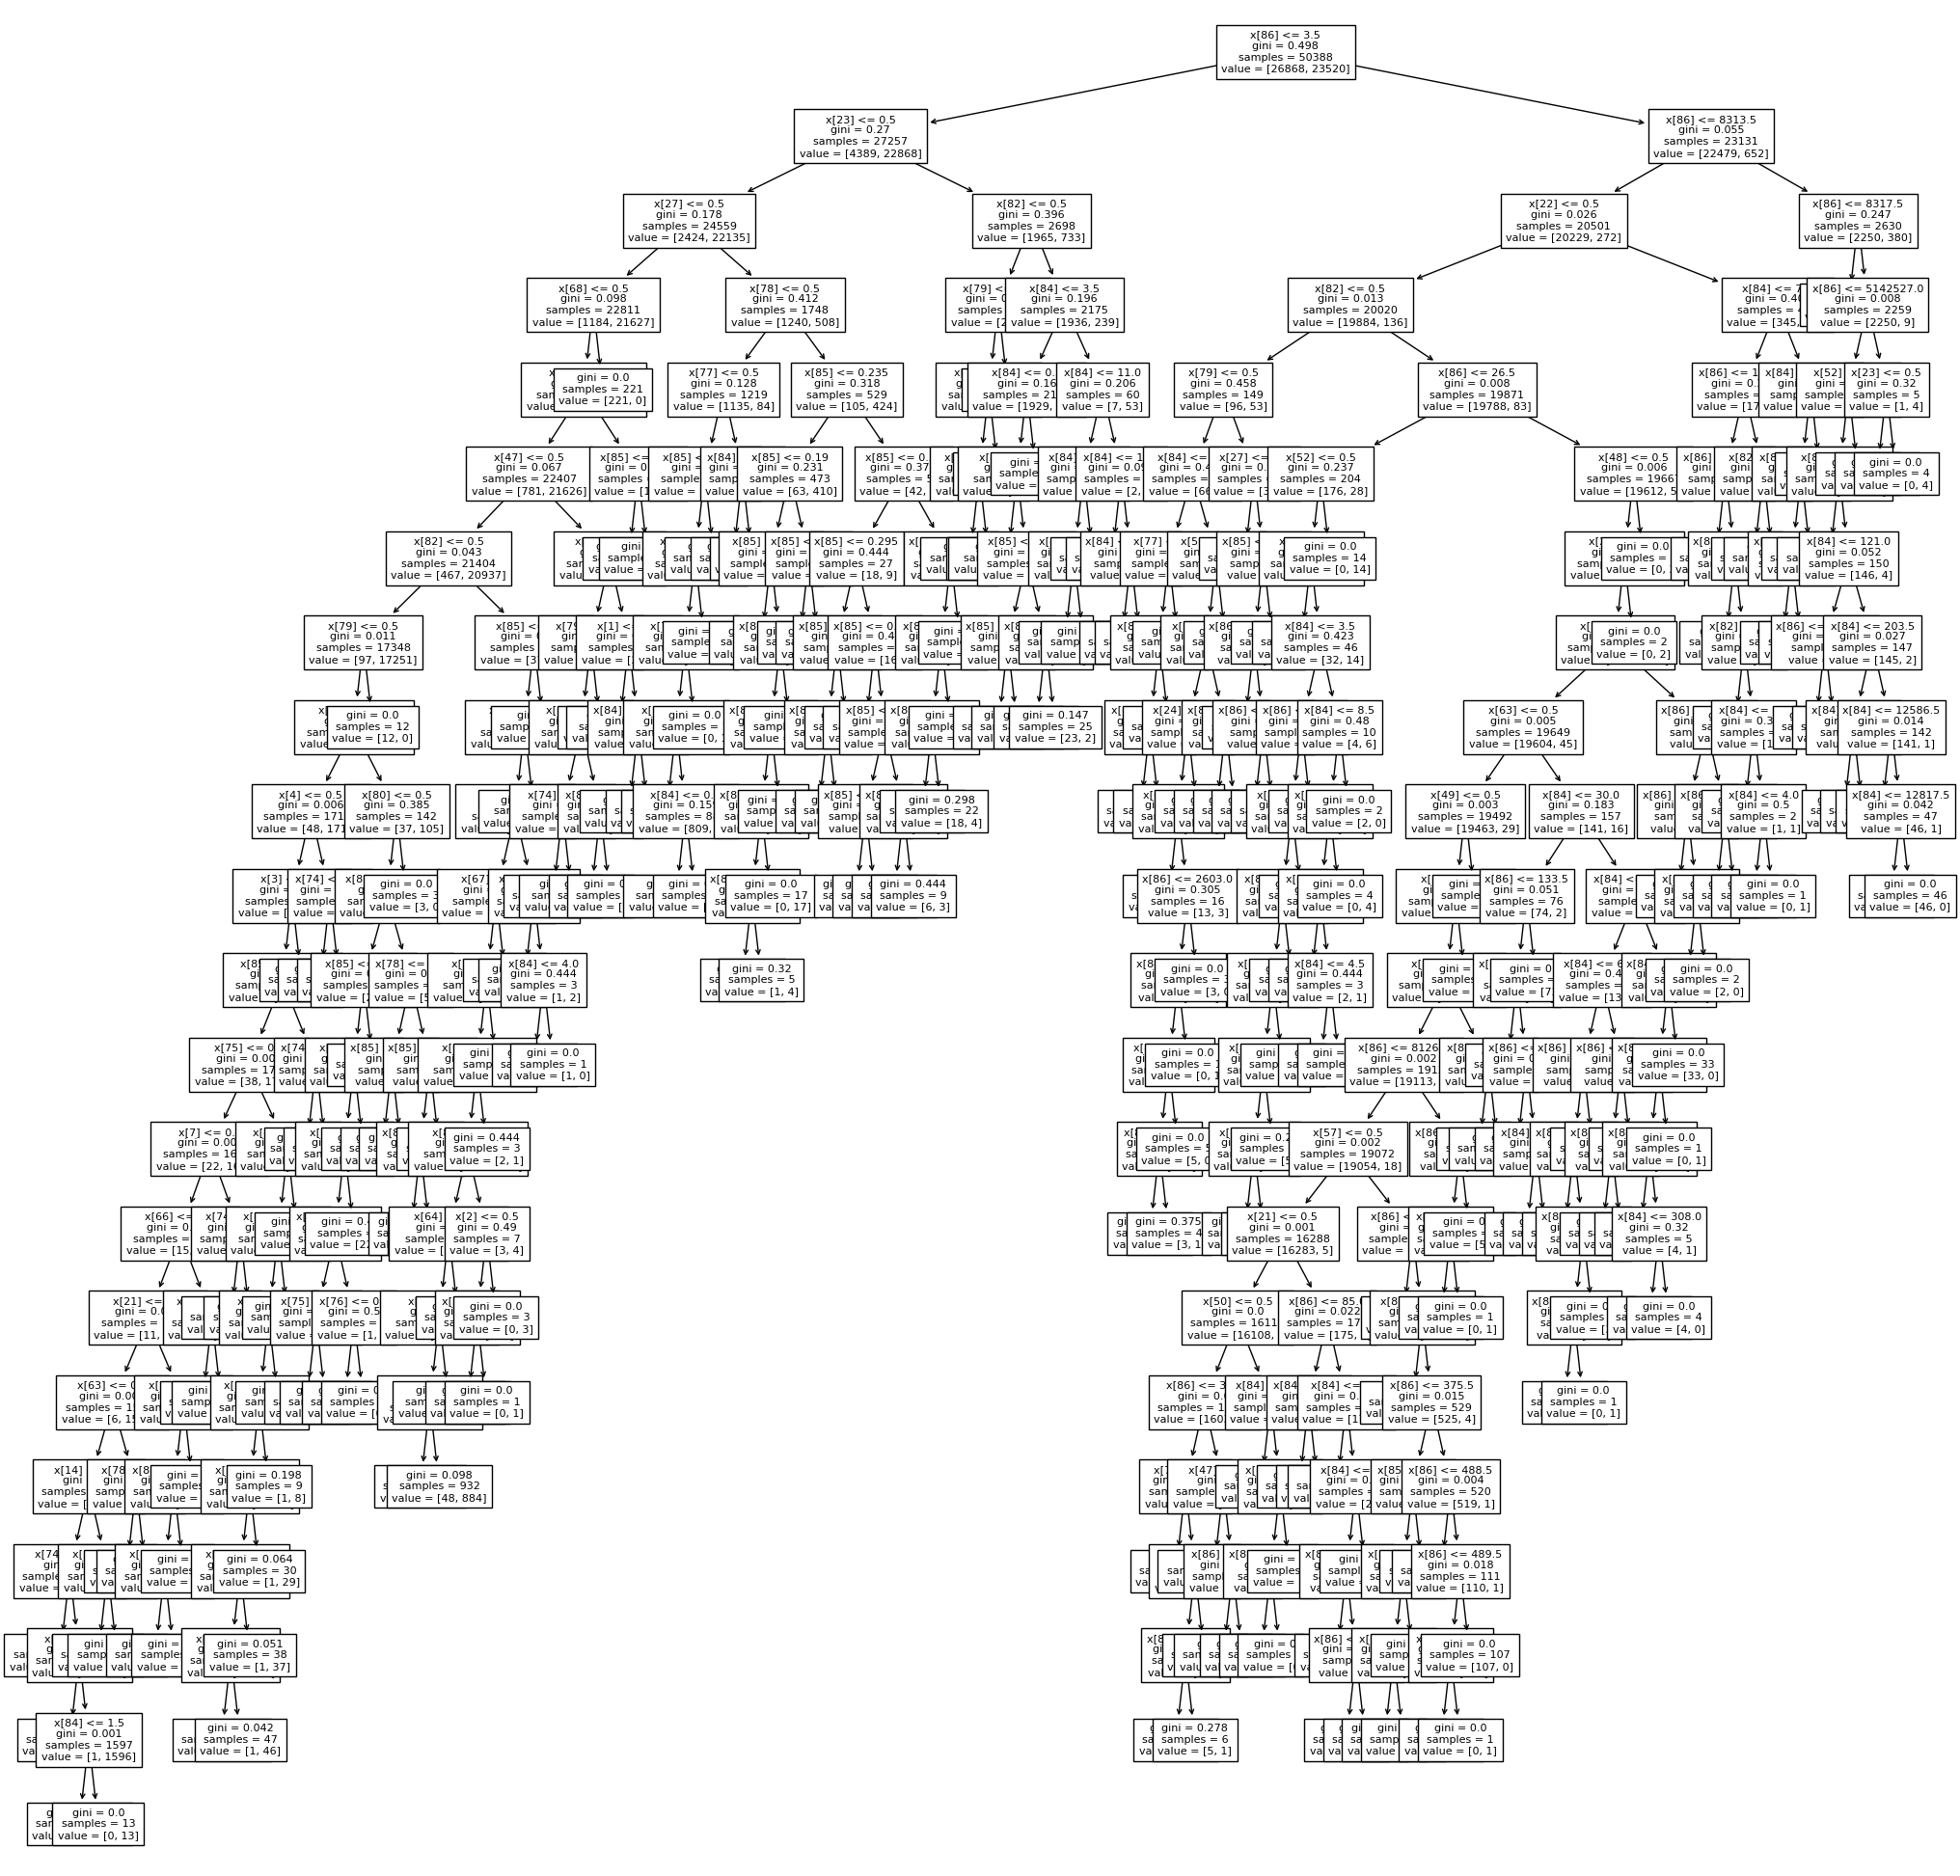

In [39]:
plt.figure(figsize=(25, 25))  # set plot size
plot_tree(binary_model, fontsize=8)
plt.show()

Loop through other Classification Machine Learning Algorithims

In [40]:
ML_results = pd.DataFrame(columns = ['Type', 'Model', 'accuracy', 
                                     'precision', 'recall', 'f1'])

model_names = ['Naive Bayes', 'K-Nearest Neighbors', 
               'Random Forest', 'Linear SVM']

models = [MultinomialNB(), KNeighborsClassifier(), 
          RandomForestClassifier(), LinearSVC()]

model_dict = dict(zip(model_names, models))

i = 1 
for model_name, model in zip(model_names, models):
  binary_model = model.fit(binary_train_X, binary_train_y)
  y_pred = binary_model.predict(binary_val_X)

  metrics_list = compute_metrics(y_pred, binary_val_y)
  results = pd.DataFrame(metrics_list, columns = ['accuracy', 'precision', 'recall', 'f1'], index=[i])
  results['Type'] = 'Classical Machine Learning'
  results['Model'] = model_name
  results = results[['Type', 'Model', 'accuracy', 'precision', 'recall', 'f1']]
  ML_results = pd.concat([ML_results, results])
  i+=1

display(ML_results)

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Type,Model,accuracy,precision,recall,f1
1,Classical Machine Learning,Naive Bayes,0.894224,0.900177,0.899266,0.894218
2,Classical Machine Learning,K-Nearest Neighbors,0.977297,0.977705,0.976702,0.977159
3,Classical Machine Learning,Random Forest,0.981676,0.981520,0.981654,0.981586
4,Classical Machine Learning,Linear SVM,0.936018,0.935543,0.937623,0.935895


Investigate the importance of each feature using the feature importance scores provided by Random Forest. Removing irrelevant or redundant features can improve the performance of the model and reduce overfitting. Then, display the important features.

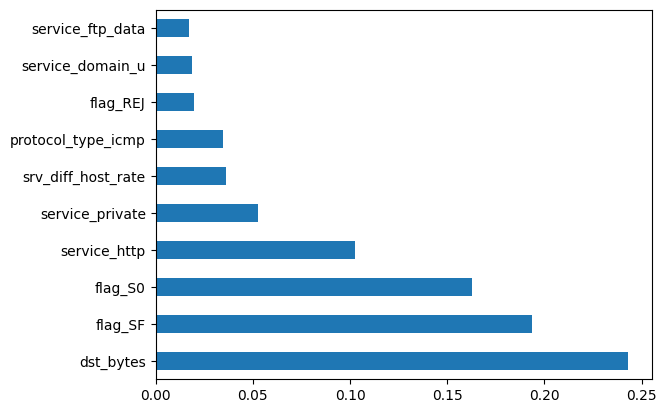

In [41]:
rf_model = RandomForestClassifier()
rf_model.fit(binary_train_X, binary_train_y)

feature_importances = pd.Series(rf_model.feature_importances_, index=to_fit.columns)
feature_importances.nlargest(10).plot(kind='barh')  # plot top 10 important features
plt.show()

Hyperparameter tuning using RandomizedSearch Cross-Validation which samples a fixed number of parameter settings from the specified distributionsis to evaluate a model with a specified set of hyperparameters. It randomly choose subsets from all possible combinations of the provided hyperparameter values to find the best ones.

In [42]:
# tuning hyperparameters for Random Forest
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None] + list(randint(10, 60).rvs(size=3)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1)
random_search.fit(binary_train_X, binary_train_y)

best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'bootstrap': False, 'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 129}


Evaluate the model using K-fold cross-validation: Use k-fold cross-validation to evaluate the model instead of using a single train-test split. This will provide a more reliable estimate of the performance of the model.

In [43]:
from sklearn.model_selection import cross_val_score

# Evaluating Random Forest model using 5-fold cross-validation
rf_model = RandomForestClassifier(**best_params)  # use best parameters from grid search
scores = cross_val_score(rf_model, to_fit, binary_y, cv=5)

print("Accuracy scores: ", scores)
print("Mean accuracy: ", np.mean(scores))

Accuracy scores:  [0.98106767 0.98031355 0.98158292 0.98301183 0.98194014]
Mean accuracy:  0.9815832231386328


Apply normalization to the important features in the dataset, and repeat the training and testing for Naive Bayes, K-Nearest Neighbors, Random Forest with tuned hyperparameters, Tuned Random Forst, Linear SVM, and two more approaches: Logistic Regressio and Gradient Boosting, to show their performance metrics.

In [44]:
ML_results = pd.DataFrame(columns=['Type', 'Model', 'accuracy',
                                   'precision', 'recall', 'f1'])

model_names = ['Multinomial Naive Bayes', 'K-Nearest Neighbors', 'Decition Tree' ,'Random Forest', 'Linear SVM', 'Logistic Regression', 'Gradient Boosting']
# Using the tuned hyperparameters for random forest 
models = [MultinomialNB(), KNeighborsClassifier(),DecisionTreeClassifier(),  
          RandomForestClassifier(**best_params), LinearSVC(), 
          LogisticRegression(), GradientBoostingClassifier()]

model_dict = dict(zip(model_names, models))

# Normalize the numerical features using MinMaxScaler
scaler = MinMaxScaler()
norm_binary_train_X = scaler.fit_transform(binary_train_X)
norm_binary_val_X = scaler.transform(binary_val_X)

i = 1
for model_name, model in zip(model_names, models):
    binary_model = model.fit(norm_binary_train_X, binary_train_y)
    y_pred = binary_model.predict(norm_binary_val_X)

    metrics_list = compute_metrics(y_pred, binary_val_y)

    results = pd.DataFrame(metrics_list, columns=['accuracy', 'precision', 'recall', 'f1'], index=[i])
    results['Type'] = 'Classical Machine Learning'
    results['Model'] = model_name
    results = results[['Type', 'Model', 'accuracy', 'precision', 'recall', 'f1']]
    ML_results = pd.concat([ML_results, results])
    i+=1

display(ML_results)

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Type,Model,accuracy,precision,recall,f1
1,Classical Machine Learning,Multinomial Naive Bayes,0.962558,0.962464,0.962261,0.962361
2,Classical Machine Learning,K-Nearest Neighbors,0.979255,0.979702,0.978652,0.979128
3,Classical Machine Learning,Decition Tree,0.981279,0.981121,0.981255,0.981187
4,Classical Machine Learning,Random Forest,0.981517,0.981367,0.981487,0.981426
5,Classical Machine Learning,Linear SVM,0.958338,0.958147,0.958103,0.958125
6,Classical Machine Learning,Logistic Regression,0.963233,0.963183,0.962897,0.963036
7,Classical Machine Learning,Gradient Boosting,0.978831,0.978809,0.978636,0.978721


The result shows cearly that Random Forest with tuned hyperparameters have best performance of accuracy and prescision. 

Confusion Matrix creation for Classification Machine Learning Algorithims

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


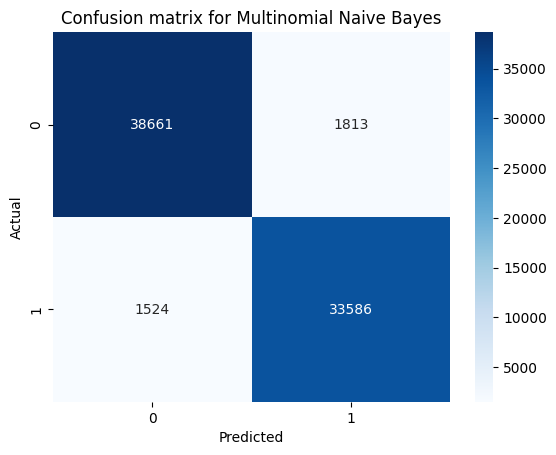

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


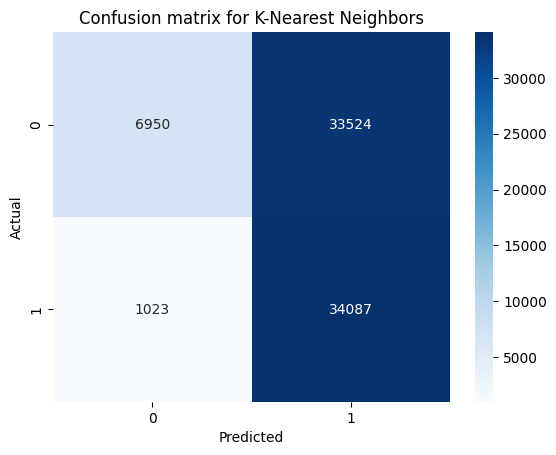

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


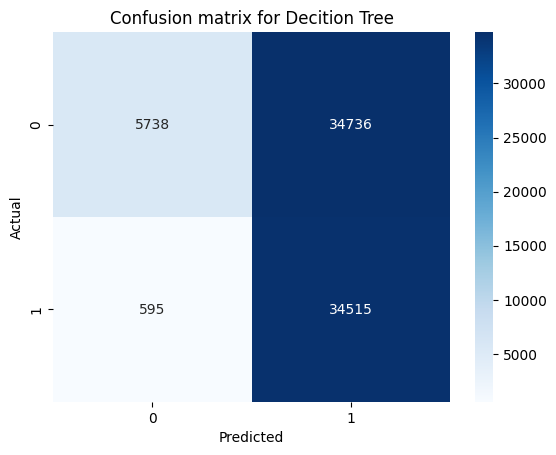

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


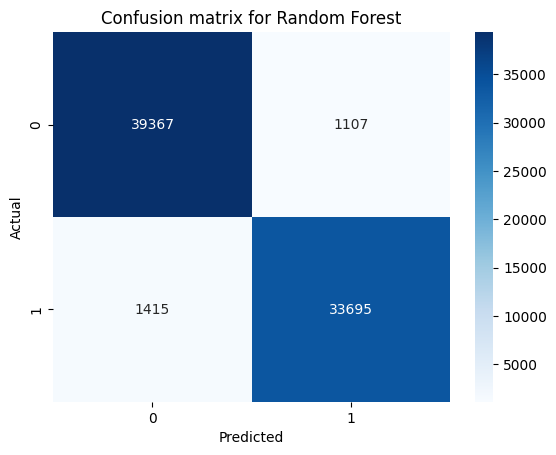

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


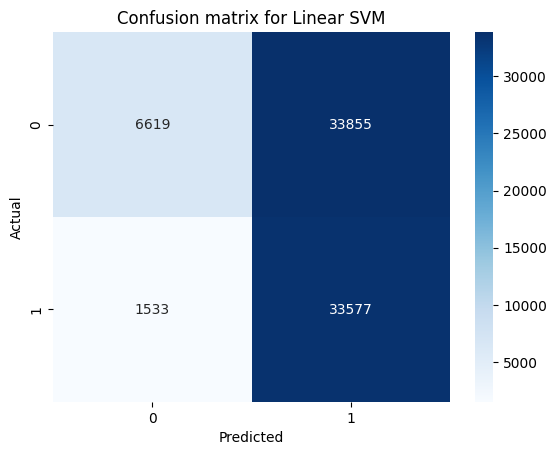

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


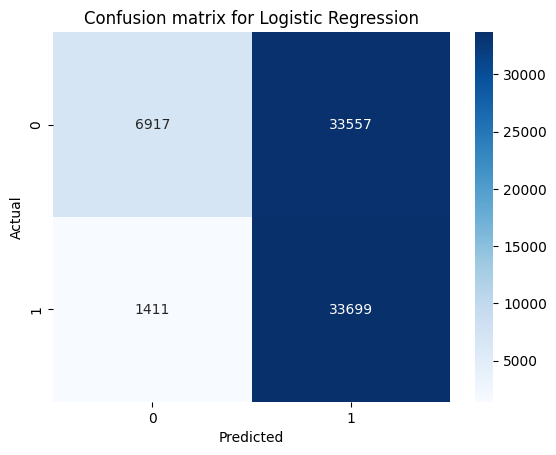

c:\Users\zhebu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


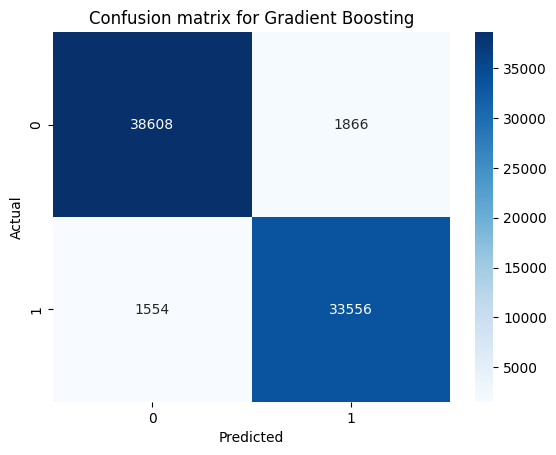

In [45]:
for model_name, model in zip(model_names, models):
  model_results = ML_results[ML_results['Model'] == model_name]
  model = model_dict[model_name]

  # Make predictions on each of the validation sets
  y_pred = model.predict(binary_val_X)

  # Get the true labels for each the validation sets
  y_true = binary_val_y

# Calculate each of the confusion matrixes
  cm = confusion_matrix(y_true, y_pred)

  # Create heatmaps for the confusion matrixes
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion matrix for {model_name}')
  plt.show()
   

ROC curve for each models, which is a graphical representation of a model's classification performance across different decision thresholds. It plots the true positive rate (sensitivity or recall) on the y-axis against the false positive rate (1-specificity) on the x-axis. The ROC curve helps to visualize the trade-off between the true positive rate and false positive rate, allowing to evaluate the performance.

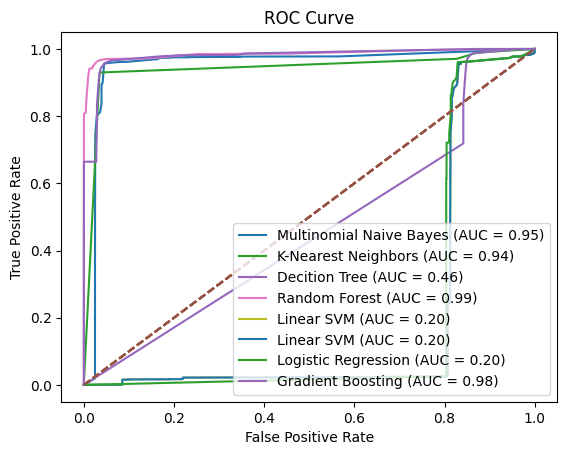

In [46]:
from sklearn.metrics import roc_curve, auc
import warnings
# ignore warnings that not critical
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning)

def plot_roc_curve(fpr, tpr, model_name, auc_score):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

# Loop through models and plot ROC curve for each
for model_name, model in zip(model_names, models):
    model_results = ML_results[ML_results['Model'] == model_name]
    model = model_dict[model_name]

    # Make probability predictions on the validation set
    if model_name == "Linear SVM":
        y_prob = model.decision_function(binary_val_X)
            # Calculate TPR, FPR, and AUC
        fpr, tpr, _ = roc_curve(binary_val_y, y_prob)
        auc_score = auc(fpr, tpr)

        # Plot ROC curve
        plot_roc_curve(fpr, tpr, model_name, auc_score)
    elif model_name == "Naive Bayes":
        # Remove MultinomialNB because it does not have probability predictions
        continue
    else:
        y_prob = model.predict_proba(binary_val_X)[:, 1]
        
            # Calculate TPR, FPR, and AUC
    fpr, tpr, _ = roc_curve(binary_val_y, y_prob)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, model_name, auc_score)

plt.show()


The AUC represents the probability that a randomly chosen positive instance will have a higher predicted probability than a randomly chosen negative instance. In general, a model with a higher AUC is considered better than a model with a lower AUC. Random Forest with tuned parameters has the most perfect classifier which has an AUC close to 1.0.

Also, classifiers often have a trade-off between TPR(True Positive Rate) and FPR(False Positive Rate), and the ROC curve helps visualize this trade-off. If the curve is closer to the top-left corner, the classifier performs well. If the curve is closer to the diagonal line, the classifier performs poorly or no better than random. From the graph, Random Forest clearly has the ROC curve is closer to the top-left corner.